In [1]:
pip install pydicom

Note: you may need to restart the kernel to use updated packages.


**Processing and Extracting Lung Nodule Annotation:** This code processes DICOM files containing lung nodule information by traversing through directories, extracting contour data from the files, and calculating key attributes like the position and diameter of the nodules. It begins by defining the root directory where DICOM files are stored and initializes lists to store the extracted data. The code reads each DICOM file, identifies regions of interest (ROIs) within the file, and extracts contour points to calculate the nodule's position and size. The nodule's position in world coordinates is then converted to pixel coordinates relative to the corresponding image slice. The script finds the DICOM slice closest to the nodule's Z-coordinate to accurately represent the nodule in the final image. After processing, the data is compiled into a DataFrame and saved as an Excel file for further analysis.

In [13]:
import os
import pydicom
import numpy as np
import pandas as pd
from scipy.spatial import distance


# Define the root directory containing subfolders with DICOM files (RTSTRUCT)
root_dir = 'C:/Users/Amir/BrainInnov/BrainInnove_Project/manifest-1724207767603/'
# Initialize lists to store nodule data
k= 1
lung_name = []
x_pos = []
y_pos = []
z_pos = []
diam = []

# Traverse the directory tree to process DICOM files
for dirpath, dirnames, filenames in os.walk(root_dir):
    for filename in filenames:
        if filename.endswith('.dcm'):  # Filter for DICOM files
            dicom_path = os.path.join(dirpath, filename)
            
            # Read the DICOM file
            rtstruct = pydicom.dcmread(dicom_path)
            for roi in rtstruct.StructureSetROISequence:
                roi_number = roi.ROINumber
                for roi_contour in rtstruct.ROIContourSequence:
                    if roi_contour.ReferencedROINumber == roi_number:
                        # Extract contours for each ROI
                        contours = []
                        for contour_sequence in roi_contour.ContourSequence:
                            contour_data = contour_sequence.ContourData
                            contour_points = np.array(contour_data).reshape(-1, 3)
                            contours.append(contour_points)
            # Stack all contours into a single array
            all_contours = np.vstack(contours)
            pairwise_distances = distance.pdist(all_contours) # Compute pairwise distances
            
            # Calculate the mean position and diameter of the nodule
            nodule_position = np.mean(all_contours, axis=0)
            nodule_diameter = np.min(pairwise_distances)
            
            # Format lung name with leading zeros
            s = str(k).zfill(3)
            lung = 'LUNG1-'+s
            lung_name.append(lung)
            
            # Define path to the corresponding DICOM files (CT images)
            path = 'C:/Users/Amir/BrainInnov/BrainInnove_Project/manifest-1724207708240/NSCLC-Radiomics/'+lung
            k+=1
            for dirpath1, dirnames1, filenames1 in os.walk(path):
                for filename1 in filenames1:
                    if filename1.endswith('.dcm'):  # Filter for DICOM files
                        dicom_path = os.path.join(dirpath1, filename1)
                        # Find the slice closest to the nodule's Z-coordinate
                        dicom_files = [os.path.join(dirpath1, f) for f in os.listdir(dirpath1) if f.endswith('.dcm')]
                        dicom_slices = []
                        for dicom_file in dicom_files:
                            # Extract image data and other relevant information
                            dicom_slice = pydicom.dcmread(dicom_file)
                            dicom_slices.append(dicom_slice)

                        # Function to get the Z-coordinate of a slice
                        def get_slice_location(dicom_slice):
                            return dicom_slice.ImagePositionPatient[2]  # Z-coordinate

                        dicom_slices.sort(key=get_slice_location)

                        # Find the slice closest to the nodule's Z-coordinate
                        closest_slice = min(dicom_slices, key=lambda slice: abs(get_slice_location(slice) - nodule_position[2]))

                        image_data = closest_slice.pixel_array
                        
                        image_position_patient = np.array(closest_slice.ImagePositionPatient)
                        pixel_spacing = np.array(closest_slice.PixelSpacing)
                        
                        # Convert nodule position from world coordinates to pixel coordinates
                        nodule_pixel_x = (nodule_position[0] - image_position_patient[0]) / pixel_spacing[0]
                        nodule_pixel_y = (nodule_position[1] - image_position_patient[1]) / pixel_spacing[1]

                        # Calculate nodule diameter in pixels
                        xmin, ymin, zmin = np.min(all_contours, axis=0)
                        xmax, ymax, zmax = np.max(all_contours, axis=0)
                        real_xmin = (xmin - image_position_patient[0]) / pixel_spacing[0]
                        real_xmax = (xmax - image_position_patient[0]) / pixel_spacing[0]
                        real_ymin = (ymin - image_position_patient[1]) / pixel_spacing[1]
                        real_ymax = (ymax - image_position_patient[1]) / pixel_spacing[1]
                        

                        dia = np.mean([real_xmax-real_xmin,real_ymax-real_ymin])
                        
                                               
                        dicom_slices = []
                        slice_z_coords = []

                        # Collect slice Z-coordinates and find the closest slice
                        for dicom_file in dicom_files:
                            dicom_slice = pydicom.dcmread(dicom_file)
                            z_coord = dicom_slice.ImagePositionPatient[2]
                            dicom_slices.append((dicom_slice, z_coord))
                            slice_z_coords.append(z_coord)

                        # Sort the slices by Z-coordinate
                        dicom_slices.sort(key=lambda x: x[1])

                        # Example nodule position (replace with actual position data)
                        nodule_z_position = nodule_position[2]  # Example Z-coordinate of the nodule

                        # Find the index of the slice closest to the nodule's Z-coordinate
                        closest_slice_index = np.argmin([abs(z - nodule_z_position) for z in slice_z_coords])
                        closest_slice_number = closest_slice_index + 1  # Slices are usually numbered starting from 1


                        closest_slice = dicom_slices[closest_slice_index][0]


                        Z = closest_slice_number
                        x_pos.append(nodule_pixel_x)
                        y_pos.append(nodule_pixel_y)
                        z_pos.append(Z)
                        diam.append(dia)
                        print(k)
                        break # Exit after processing the first DICOM file in the folder

# Create a DataFrame from the collected data
data = {
    'lung_name': lung_name,  # Replace with your actual data
    'x-pos': x_pos,                # Replace with your actual data
    'y-pos': y_pos,                # Replace with your actual data
    'z-pos': z_pos,                # Replace with your actual data
    'dia': diam                 # Replace with your actual data
}
# Create a DataFrame
df = pd.DataFrame(data)
# Write the DataFrame to an Excel file
output_path = 'lung_nodule_data.xlsx'

df.to_excel(output_path, index=False)



2
3
4
5
6
7
8
9
10
11


In [14]:
import pandas as pd
import numpy as np

# Loading and Displaying Lung Nodule Data from an Excel File
file_path = 'lung_nodule_data.xlsx'
df = pd.read_excel(file_path)
print(df)

     lung_name       x-pos       y-pos  z-pos         dia
0    LUNG1-001  190.075427  272.766053     74  190.863360
1    LUNG1-002  182.106249  272.602799     72   99.672467
2    LUNG1-003  305.110428  253.777633     20   59.380757
3    LUNG1-004  316.562048  336.627413     83   66.841600
4    LUNG1-005  195.791061  261.483038     37   78.817810
..         ...         ...         ...    ...         ...
417  LUNG1-418  316.902651  290.418092     53  108.590080
418  LUNG1-419  177.409936  221.029670     62   87.475200
419  LUNG1-420  310.701668  333.748897     71   39.541760
420  LUNG1-421  316.625274  228.135689     46   55.040000
421  LUNG1-422  228.858014  301.264879     60   43.735040

[422 rows x 5 columns]


**Analysis and Visualization of Lung Nodule Annotations:** This code analyzes lung nodule diameter data from an Excel file and visualizes the distribution of nodules across different diameter ranges. The script begins by loading the dataset from the specified Excel file (lung_nodule_data.xlsx) and extracts the diameter column. It then calculates and prints the smallest and largest nodule diameters. The nodules are grouped into predefined diameter ranges (e.g., <30, 30-60, etc.), and the script counts the number of nodules within each range. These counts are visualized using a bar chart, where the x-axis represents the diameter ranges and the y-axis represents the count of nodules. The script also determines which diameter category contains the largest number of nodules and prints this information. This analysis helps in understanding the distribution of nodule sizes within the dataset.

The smallest nodule diameter: 10.18
The largest nodule diameter: 260.67


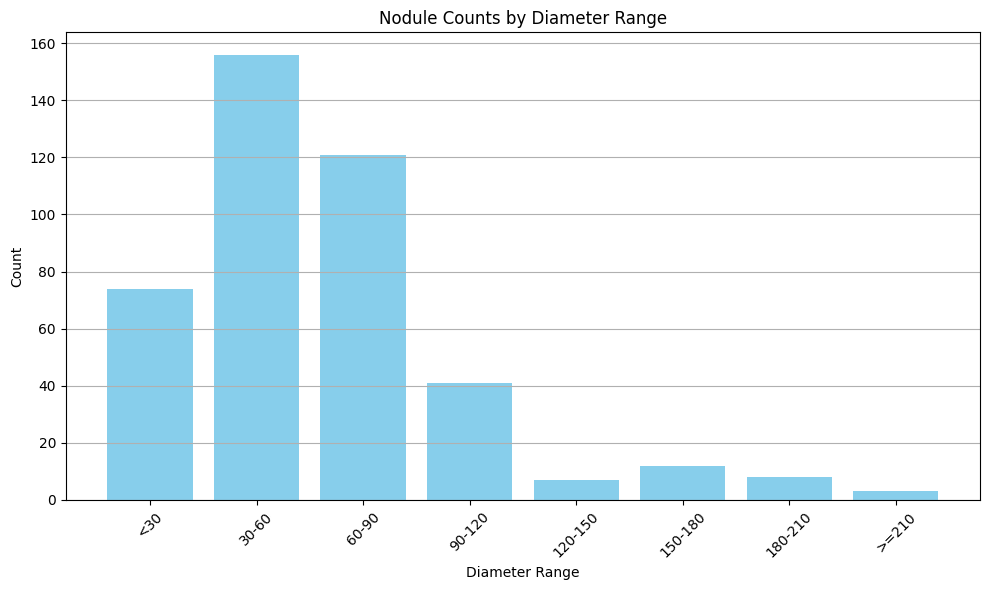

The diameter category with the largest number of nodules is '30-60' with 156 nodules.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset from the Excel file
file_path = 'lung_nodule_data.xlsx'
df = pd.read_excel(file_path)

# Extract the diameter column
diameter = df['dia']

# Compute the smallest and largest nodule diameters
smallest_diameter = np.min(diameter)
largest_diameter = np.max(diameter)

# Print the smallest and largest nodule diameters
print(f'The smallest nodule diameter: {smallest_diameter:.2f}')
print(f'The largest nodule diameter: {largest_diameter:.2f}')

# Define diameter ranges and calculate counts for each range
diameter_ranges = [(0, 30), (30, 60), (60, 90), (90, 120), 
                    (120, 150), (150, 180), (180, 210), (210, np.inf)]
range_labels = ['<30', '30-60', '60-90', '90-120', 
                '120-150', '150-180', '180-210', '>=210']
counts = [np.sum((diameter >= lower) & (diameter < upper)) 
          for lower, upper in diameter_ranges]

# Create a bar chart for nodule counts by diameter range
plt.figure(figsize=(10, 6))
plt.bar(range_labels, counts, color='skyblue')
plt.xlabel('Diameter Range')
plt.ylabel('Count')
plt.title('Nodule Counts by Diameter Range')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

# Determine the diameter category with the largest number of nodules
max_count = np.max(counts)
max_category = range_labels[np.argmax(counts)]

print(f"The diameter category with the largest number of nodules is '{max_category}' with {max_count} nodules.")


**Visualization of Lung Nodule Distribution Across CT Scan Slices Using Excel Data:** This code reads lung nodule data from an Excel file and visualizes the distribution of nodules across different slices (z-positions) in a CT scan. The script first loads the data from the specified Excel file (lung_nodule_data.xlsx). It then groups the data by the z-position (z-pos) of each slice and counts the number of nodules present in each slice. This count is visualized using a bar chart, where the x-axis represents the slice number (z-pos),and the y-axis represents the number of nodules. The chart provides an intuitive way to see how nodules are distributed across different slices, which could be useful for analyzing the spatial distribution of nodules within the lung.

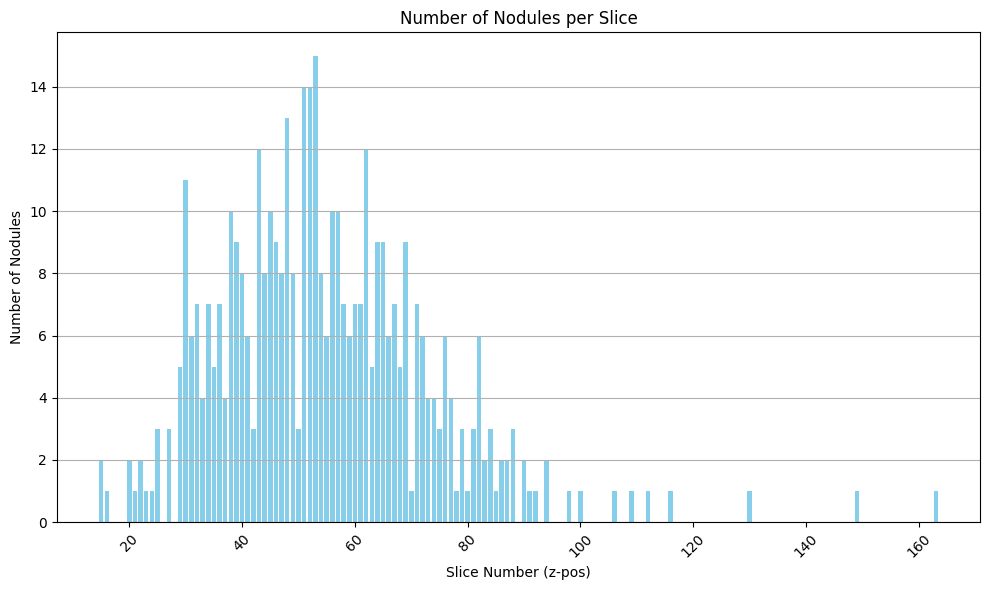

In [16]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the Excel file
file_path = 'lung_nodule_data.xlsx'
df = pd.read_excel(file_path)

# Count the number of nodules per slice (z-pos)
nodule_counts_per_slice = df.groupby('z-pos').size()

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(nodule_counts_per_slice.index, nodule_counts_per_slice.values, color='skyblue')
plt.xlabel('Slice Number (z-pos)')
plt.ylabel('Number of Nodules')
plt.title('Number of Nodules per Slice')
plt.xticks(rotation=45)
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()


**Processing and Organizing Lung Nodule Data::** This code processes a set of lung nodule data by extracting relevant information from DICOM files and copying specific slices to a new folder. The script begins by loading lung nodule data from an Excel file (lung_nodule_data.xlsx) into a pandas DataFrame. It then initializes a NumPy array to store various attributes, including the Z-coordinate, diameter, and X/Y coordinates of the nodules. 
For each nodule, the code identifies and copies three specific DICOM slices from a source folder to a target folder: the slice just before, at, and just after the nodule’s Z-position. These slices are renamed based on the nodule's index and their relative position (lower, original, or upper) before being copied. This operation is useful for organizing the DICOM files in a structured way for further analysis or processing. The script also creates the destination folder if it doesn't exist and provides feedback by printing the index of each processed image.

In [23]:
import numpy as np
import pandas as pd
import os
import shutil

#################### Functions ######################

# Load the dataset from an Excel file
df = pd.read_excel('lung_nodule_data.xlsx')

# Extract the 'lung_name' column from the DataFrame
file_name = df['lung_name']

# Initialize an array with shape (number of rows in df, 5)
u = np.zeros((len(df), 5))
# Fill the array with appropriate data
u[:, 0] = 0  # Placeholder column
u[:, 1] = df['z-pos']  # Z-coordinate of nodules
u[:, 2] = df['dia']  # Diameter of nodules
u[:, 3] = df['y-pos']  # Y-coordinate of nodules
u[:, 4] = df['x-pos']  # X-coordinate of nodules

# Define the path for the new folder where files will be copied
new_folder_path = 'C:/Users/Amir/BrainInnov/BrainInnove_Project/Dataset/'
# Create the folder if it does not exist
if not os.path.exists(new_folder_path):
    os.makedirs(new_folder_path)

# Define the number of images to process
num_image,_ = u.shape  

# Loop through each image index
for i in range(num_image):
    # Create an empty 3-channel (RGB) image of size 512x512
    img = np.zeros((512, 512, 3))
    # Generate the lung name based on the index
    s = str(i + 1).zfill(3)
    lung = 'LUNG1-' + s
    # Define the path to the corresponding folder with DICOM files
    path = 'C:/Users/Amir/BrainInnov/BrainInnove_Project/manifest-1724207708240/NSCLC-Radiomics/' + lung

    # Walk through the directory to process each DICOM file
    for dirpath1, _, filenames1 in os.walk(path):
        for filename1 in filenames1:
            if filename1.endswith('.dcm'):  # Filter for DICOM files
                # Extract slice number from filename
                ind1 = filename1.find('-')
                ind2 = filename1.find('.')
                num = int(filename1[ind1 + 1:ind2])

                # Check if the slice number matches specific criteria and copy the file to the new folder
                if num == u[i, 1] - 1:
                    dicom_path = os.path.join(dirpath1, filename1)
                    new_file_name = str(i + 1) + '-' + 'l' + '.dcm'
                    new_file_path = os.path.join(new_folder_path, new_file_name)
                    shutil.copy(dicom_path, new_file_path)

                if num == u[i, 1]:
                    dicom_path = os.path.join(dirpath1, filename1)
                    new_file_name = str(i + 1) + '-' + 'o' + '.dcm'
                    new_file_path = os.path.join(new_folder_path, new_file_name)
                    shutil.copy(dicom_path, new_file_path)

                if num == u[i, 1] + 1:
                    dicom_path = os.path.join(dirpath1, filename1)
                    new_file_name = str(i + 1) + '-' + 'u' + '.dcm'
                    new_file_path = os.path.join(new_folder_path, new_file_name)
                    shutil.copy(dicom_path, new_file_path)

    # Print the index of the processed image
    #print(i)


**Visualization of Lung Nodules in DICOM Images with Bounding Boxes:** This script is designed to visualize lung nodules in DICOM images with their corresponding bounding boxes. It starts by loading lung nodule data from an Excel file and extracts relevant nodule information such as the Z-coordinate, diameter, and X/Y coordinates. The user is prompted to input an image number, and the corresponding DICOM slices are read to form a composite RGB image. The bounding box around the nodule is calculated using a custom function that converts the nodule's center coordinates and diameter to the PASCAL VOC format (min-max coordinates). This bounding box is then overlaid on the green channel of the composite image using Matplotlib, allowing for visual inspection of the nodule's location relative to the rest of the image.

Input the image number: 6


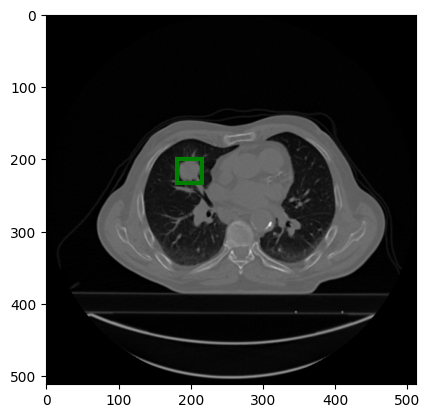

In [24]:
import pydicom
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def to_VOC_format(width, height, center_x, center_y):
    """
    Convert center coordinates format to VOC format (min-max coordinates)
    
    Parameters:
    - width (float): The width of the bounding box
    - height (float): The height of the bounding box
    - center_x (float): The x-coordinate of the center of the bounding box
    - center_y (float): The y-coordinate of the center of the bounding box
    
    Returns:
    - x_min (float): The minimum x-coordinate of the bounding box
    - y_min (float): The minimum y-coordinate of the bounding box
    - x_max (float): The maximum x-coordinate of the bounding box
    - y_max (float): The maximum y-coordinate of the bounding box
    """
    x_min = center_x - 0.5 * width
    y_min = center_y - 0.5 * height
    x_max = center_x + 0.5 * width
    y_max = center_y + 0.5 * height
    return x_min, y_min, x_max, y_max

# Input the image number from the user
i = eval(input('Input the image number:'))

# Load annotation data from Excel file
df = pd.read_excel('lung_nodule_data.xlsx')

# Prepare data array
u = np.zeros((len(df), 5))
u[:, 0] = 0
u[:, 1] = df['z-pos']  # Z-coordinate of the nodules
u[:, 2] = df['dia']    # Diameter of the nodules
u[:, 3] = df['y-pos']  # Y-coordinate of the nodules
u[:, 4] = df['x-pos']  # X-coordinate of the nodules

# Define paths to DICOM files for the image
image1 = 'Dataset/%d-l.dcm' % (i + 1)
image2 = 'Dataset/%d-l.dcm' % (i + 1)
image3 = 'Dataset/%d-l.dcm' % (i + 1)

# Read DICOM files and extract pixel arrays
images1 = pydicom.read_file(image1)
img_data1 = images1.pixel_array

images2 = pydicom.read_file(image2)
img_data2 = images2.pixel_array

images3 = pydicom.read_file(image3)
img_data3 = images3.pixel_array

# Create a composite RGB image from the DICOM slices
img = np.zeros((512, 512, 3))
img[:, :, 0] = img_data1  # Red channel
img[:, :, 1] = img_data2  # Green channel
img[:, :, 2] = img_data3  # Blue channel

# Convert the bounding box from center coordinates to VOC format
x_min, y_min, x_max, y_max = to_VOC_format(u[i, 2], u[i, 2], u[i, 3], u[i, 4])
bbox_list = np.int16(np.array([x_min, y_min, x_max, y_max]))

# Create a plot to visualize the image and the grand truth bounding box
fig, ax = plt.subplots()
plt.imshow(img[:, :, 1], cmap='gray')  # Display the green channel image
rect = patches.Rectangle((bbox_list[1], bbox_list[0]), bbox_list[2] - bbox_list[0], bbox_list[2] - bbox_list[0], linewidth=3, edgecolor='g', facecolor='none')
ax.add_patch(rect)  # Add the bounding box to the plot
plt.show()  # Display the plot
